##  Work on Gpu

For the purpose of training I worked on GPU

In [2]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---
NOTE: my model called model2.py

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [3]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [4]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from model2 import Net

#GPU

net = Net().to(device)


print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (batchn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  (batchn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (batchn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=20000, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=136, bias=True)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [5]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [6]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [7]:
# load training data in batches
batch_size = 128

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [8]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)



In [9]:
print('Number of images: ', len(test_dataset))

Number of images:  770


In [10]:
# load test data in batches
batch_size = 128

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [11]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        
        
        #images = images.type(torch.FloatTensor)
        images = images.type(torch.cuda.FloatTensor)
        
        
        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [12]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([128, 1, 224, 224])
torch.Size([128, 68, 2])
torch.Size([128, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [13]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

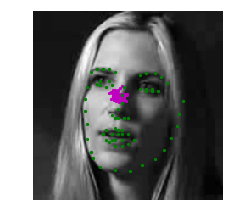

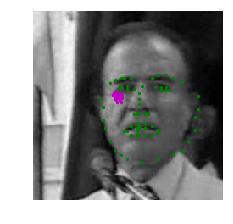

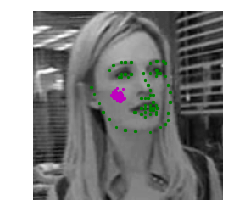

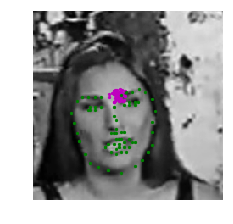

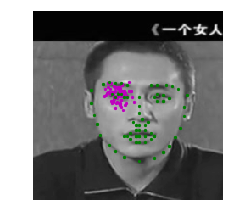

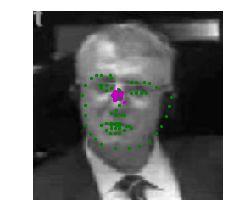

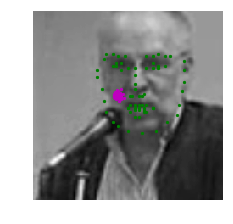

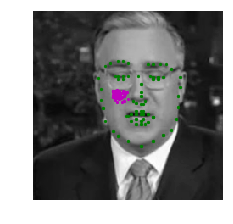

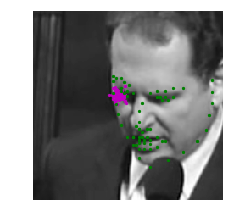

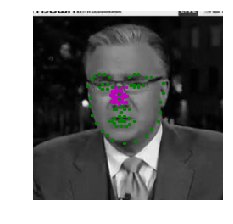

In [14]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(40,30))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        
        image = image.cuda()
        image = image.cpu().numpy()   # convert to numpy array from a Tensor
        
        
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        
        
        predicted_key_pts=predicted_key_pts.cuda()
        predicted_key_pts = predicted_key_pts.cpu().numpy()
        
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [15]:
## TODO: Define the loss and optimization
import torch.optim as optim

# Creates a criterion that measures the mean squared error between n elements in the input x and target y.
criterion =nn.MSELoss()
optimizer = optim.Adam(net.parameters())

## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [17]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()
    
    losses = []

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.cuda.FloatTensor)
            images = images.type(torch.cuda.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            
            if batch_i % 20 == 19:    # print every 20 batches
                
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0
                
                
                
        losses.append(running_loss)
        


    print('Finished Training')
    return losses


In [18]:
# train your network
n_epochs = 35 # start small, and increase when you've decided on your model structure and hyperparams

import time
start = time.time()

losses=train_net(n_epochs)

end = time.time()
print(end - start)

Epoch: 1, Batch: 20, Avg. Loss: 0.005161047533154488
Epoch: 2, Batch: 20, Avg. Loss: 0.002370893195271492
Epoch: 3, Batch: 20, Avg. Loss: 0.0017605689242482184
Epoch: 4, Batch: 20, Avg. Loss: 0.0018253805339336396
Epoch: 5, Batch: 20, Avg. Loss: 0.001559566605836153
Epoch: 6, Batch: 20, Avg. Loss: 0.00122994190081954
Epoch: 7, Batch: 20, Avg. Loss: 0.001126422181725502
Epoch: 8, Batch: 20, Avg. Loss: 0.0011892635710537434
Epoch: 9, Batch: 20, Avg. Loss: 0.0010212329160422086
Epoch: 10, Batch: 20, Avg. Loss: 0.0008478184659034013
Epoch: 11, Batch: 20, Avg. Loss: 0.0006932643819600344
Epoch: 12, Batch: 20, Avg. Loss: 0.0006341238021850586
Epoch: 13, Batch: 20, Avg. Loss: 0.0005624754335731268
Epoch: 14, Batch: 20, Avg. Loss: 0.00045859550684690473
Epoch: 15, Batch: 20, Avg. Loss: 0.0005285806637257337
Epoch: 16, Batch: 20, Avg. Loss: 0.0004660988561809063
Epoch: 17, Batch: 20, Avg. Loss: 0.00047075420245528223
Epoch: 18, Batch: 20, Avg. Loss: 0.0006256968602538109
Epoch: 19, Batch: 20, A

# Visulize MSE 128 batch epoch 35

In [19]:
losses_128_35=losses
losses

[1.007146954536438,
 0.7739957869052887,
 0.5781721509993076,
 0.6534089222550392,
 0.5764500088989735,
 0.4759281165897846,
 0.44999437034130096,
 0.4718396943062544,
 0.3501822967082262,
 0.30991530418395996,
 0.22823220305144787,
 0.24021614529192448,
 0.21420603059232235,
 0.3396125379949808,
 0.23232926428318024,
 0.17800053395330906,
 0.20790785178542137,
 0.3017903435975313,
 0.25385503750294447,
 0.21188822947442532,
 0.1521309306845069,
 0.18631144613027573,
 0.1645278912037611,
 0.24703546799719334,
 0.14462120551615953,
 0.1292543187737465,
 0.23711092676967382,
 0.11410243064165115,
 0.15437324158847332,
 0.1443167021498084,
 0.11427200958132744,
 0.12144880881533027,
 0.23795728106051683,
 0.17560357693582773,
 0.1968902675434947]

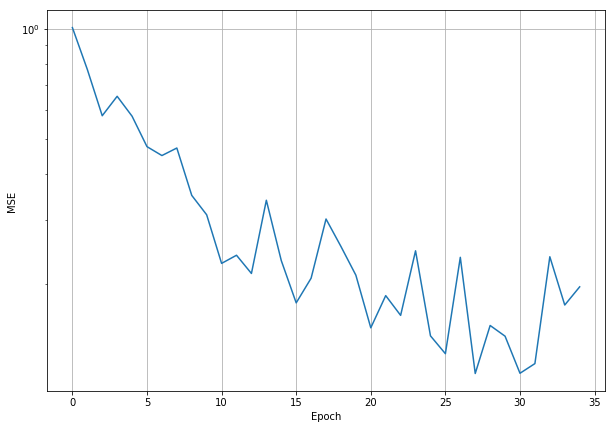

In [20]:
plt.figure(figsize=(10,7))
plt.semilogy(losses_128_35)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('MSE');

In [21]:
losses=train_net(20)

Epoch: 1, Batch: 20, Avg. Loss: 0.0003504791622981429
Epoch: 2, Batch: 20, Avg. Loss: 0.0004582626968622208
Epoch: 3, Batch: 20, Avg. Loss: 0.00036009601037949323
Epoch: 4, Batch: 20, Avg. Loss: 0.0003869981402531266
Epoch: 5, Batch: 20, Avg. Loss: 0.0002771986154839396
Epoch: 6, Batch: 20, Avg. Loss: 0.0002831856096163392
Epoch: 7, Batch: 20, Avg. Loss: 0.0002824579328298569
Epoch: 8, Batch: 20, Avg. Loss: 0.00026204312779009345
Epoch: 9, Batch: 20, Avg. Loss: 0.00024132577702403067
Epoch: 10, Batch: 20, Avg. Loss: 0.00023990937042981387
Epoch: 11, Batch: 20, Avg. Loss: 0.00026793935243040324
Epoch: 12, Batch: 20, Avg. Loss: 0.00027436288818717
Epoch: 13, Batch: 20, Avg. Loss: 0.00026410941313952205
Epoch: 14, Batch: 20, Avg. Loss: 0.00022536974120885133
Epoch: 15, Batch: 20, Avg. Loss: 0.00024379383958876132
Epoch: 16, Batch: 20, Avg. Loss: 0.0002585289548151195
Epoch: 17, Batch: 20, Avg. Loss: 0.0002299048025161028
Epoch: 18, Batch: 20, Avg. Loss: 0.00022483483329415323
Epoch: 19, B

In [22]:
losses

[0.2383234817534685,
 0.1503635011613369,
 0.1426417576149106,
 0.1263614734634757,
 0.18484401237219572,
 0.12021497078239918,
 0.0958206532523036,
 0.09535046759992838,
 0.12219521217048168,
 0.14068739116191864,
 0.09722002036869526,
 0.11498183663934469,
 0.1005544625222683,
 0.08173234621062875,
 0.0798525158315897,
 0.07471589604392648,
 0.07813319750130177,
 0.0888947220519185,
 0.09279993735253811,
 0.08324540080502629]

In [27]:
losses=train_net(15)

Epoch: 1, Batch: 20, Avg. Loss: 0.00023296438902616502
Epoch: 2, Batch: 20, Avg. Loss: 0.00021835852321237326
Epoch: 3, Batch: 20, Avg. Loss: 0.00023360644374042749
Epoch: 4, Batch: 20, Avg. Loss: 0.0002266576373949647
Epoch: 5, Batch: 20, Avg. Loss: 0.00023131610499694944
Epoch: 6, Batch: 20, Avg. Loss: 0.00020392926223576069
Epoch: 7, Batch: 20, Avg. Loss: 0.00019952532276511193
Epoch: 8, Batch: 20, Avg. Loss: 0.00018227805802598594
Epoch: 9, Batch: 20, Avg. Loss: 0.00017986512696370482
Epoch: 10, Batch: 20, Avg. Loss: 0.00018533416232094168
Epoch: 11, Batch: 20, Avg. Loss: 0.0002113580866716802
Epoch: 12, Batch: 20, Avg. Loss: 0.0001791137377731502
Epoch: 13, Batch: 20, Avg. Loss: 0.0002953379293903708
Epoch: 14, Batch: 20, Avg. Loss: 0.0002789584947749972
Epoch: 15, Batch: 20, Avg. Loss: 0.00026985261403024197
Finished Training


In [28]:
losses

[0.06739724520593882,
 0.08585548168048263,
 0.08513313438743353,
 0.06981982756406069,
 0.08950304239988327,
 0.07146086823195219,
 0.06812809035181999,
 0.07448418717831373,
 0.07333335606381297,
 0.0796097507700324,
 0.0638233651407063,
 0.06559226382523775,
 0.09379381034523249,
 0.11274912022054195,
 0.08513383287936449]

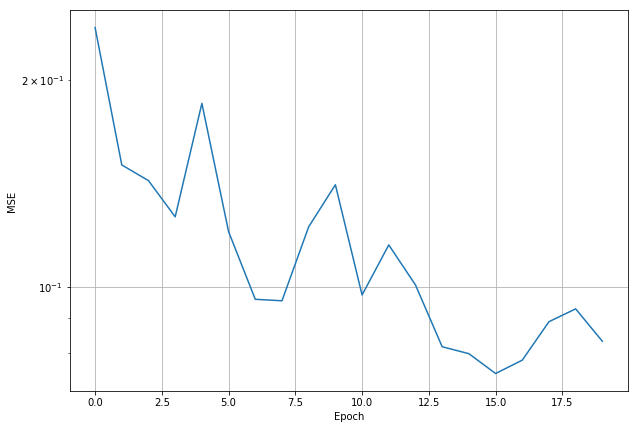

In [23]:
losses_128_55=losses
plt.figure(figsize=(10,7))
plt.semilogy(losses_128_55)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('MSE');

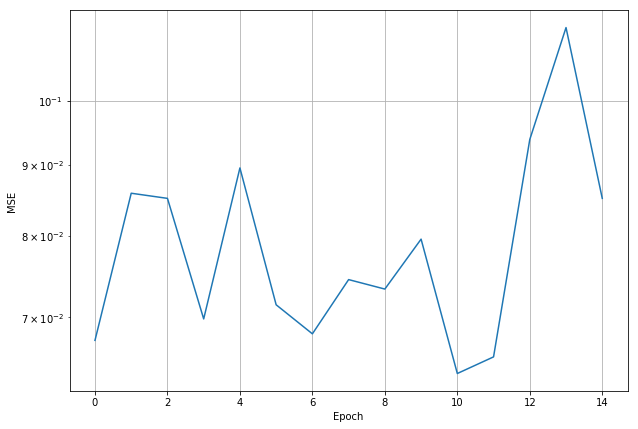

In [33]:
losses_128_70=losses
plt.figure(figsize=(10,7))
plt.semilogy(losses_128_70)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('MSE');

# Visulize MSE 10 batch 35 epoch

losses_10_35=losses

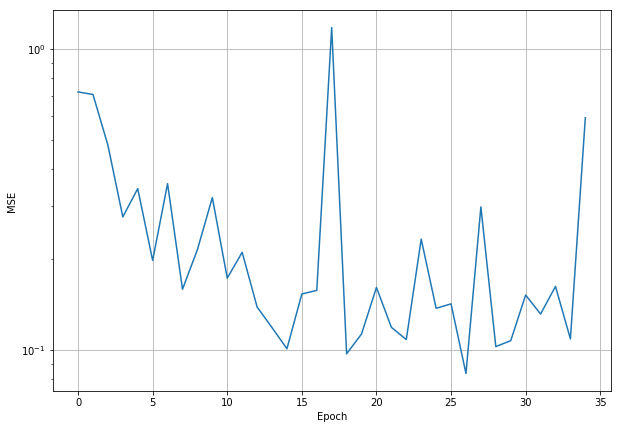

In [25]:
plt.figure(figsize=(10,7))
plt.semilogy(losses_10_35)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('MSE');

# The best model:

* batch size =128 
* epoch =70

* modelsaved : btach128_epoch70_keypoints_model_MSELoss.pt

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [30]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([128, 1, 224, 224])
torch.Size([128, 68, 2])
torch.Size([128, 68, 2])


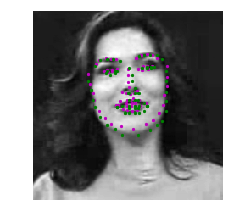

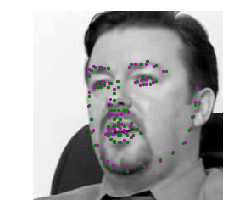

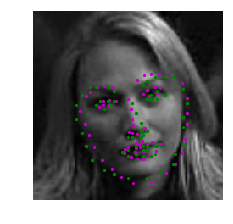

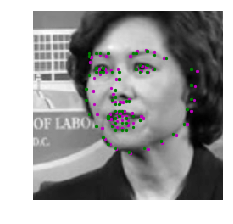

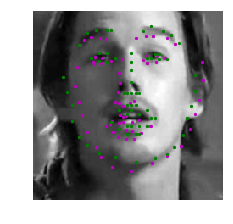

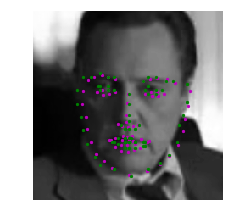

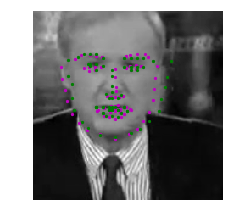

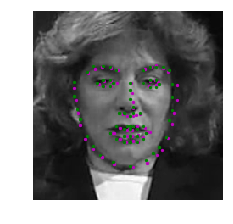

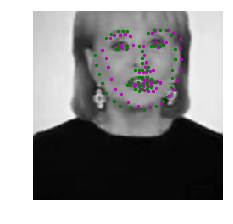

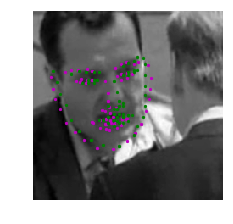

In [31]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

In [32]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'btach128_epoch70_keypoints_model_MSELoss.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**:  This is a regression problem which measures the distance from reality so I used Mean Squares Error.
For optimizer I had two choices: Adam and SGD with lr_0.001. Adam was faster that SGD and also was updating lr which is good in my my network wise.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: My network has 3 convolutional layer, pooling and normalization layer. 
Pooling layers are for avoid overfitting. I had dropout layer before dense layer but I removed it as the model was performing better without that. Also our problem could be solved as it was not a high complex problem to solve.
Results were flatten and 2 linear leyer were added. ( for that I had just one layer and then getting help from my collegue, I added 2 more layers as well.)

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**:  Smaller batch number results in faster operation but more scatter result as we go through the network. So I went for a bigger batch size to let my model see the whole senario better. I tried different batch numbers also, and by error graph I decided to go for batch 128, Also epoch 70 as after that I could not see improvement on error anymore and my example pictures were satisfying enough.However I started with smaller batch as I did not want to use GPU. Then I ran out of memory so I switch and tried different batched and more epoch to try different parameter to reach error less than 0.0005.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[ 0.04849557 -0.25149724  0.13222973  0.03478775 -0.20103355]
 [-0.23788707 -0.01827573  0.12045232 -0.12098608  0.12071232]
 [-0.02421105 -0.04409685 -0.22021711 -0.10825428  0.0764543 ]
 [ 0.0499595  -0.1479135   0.02755737  0.15180269 -0.11973616]
 [-0.06330483  0.1482677   0.20405841  0.09423192  0.13612229]]
(5, 5)


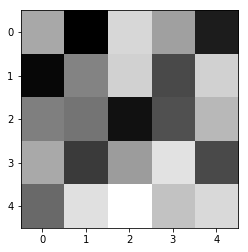

In [47]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
        
weights1 = net.conv1.weight.data

w = weights1.cpu().numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

First convolutional layer


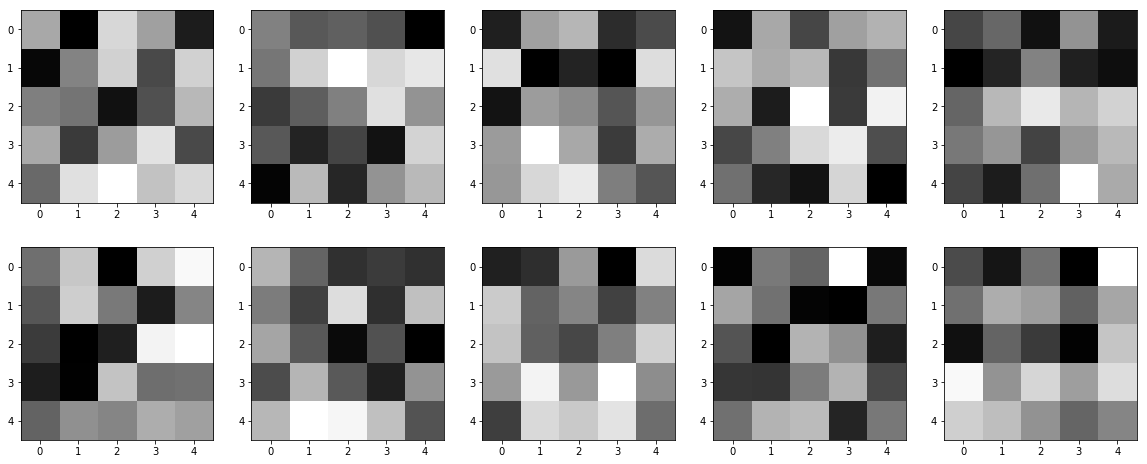

In [49]:
##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
# Get the weights in the first conv layer
weights = net.conv1.weight.data
w = weights.cpu().numpy()

# for 10 filters
fig=plt.figure(figsize=(20, 8))
columns = 5
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(w[i][0], cmap='gray')
    
print('First convolutional layer')
plt.show()

weights = net.conv2.weight.data
w = weights.cpu().numpy()

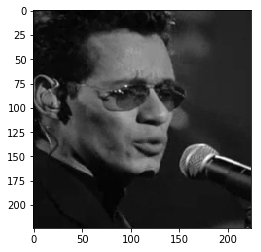

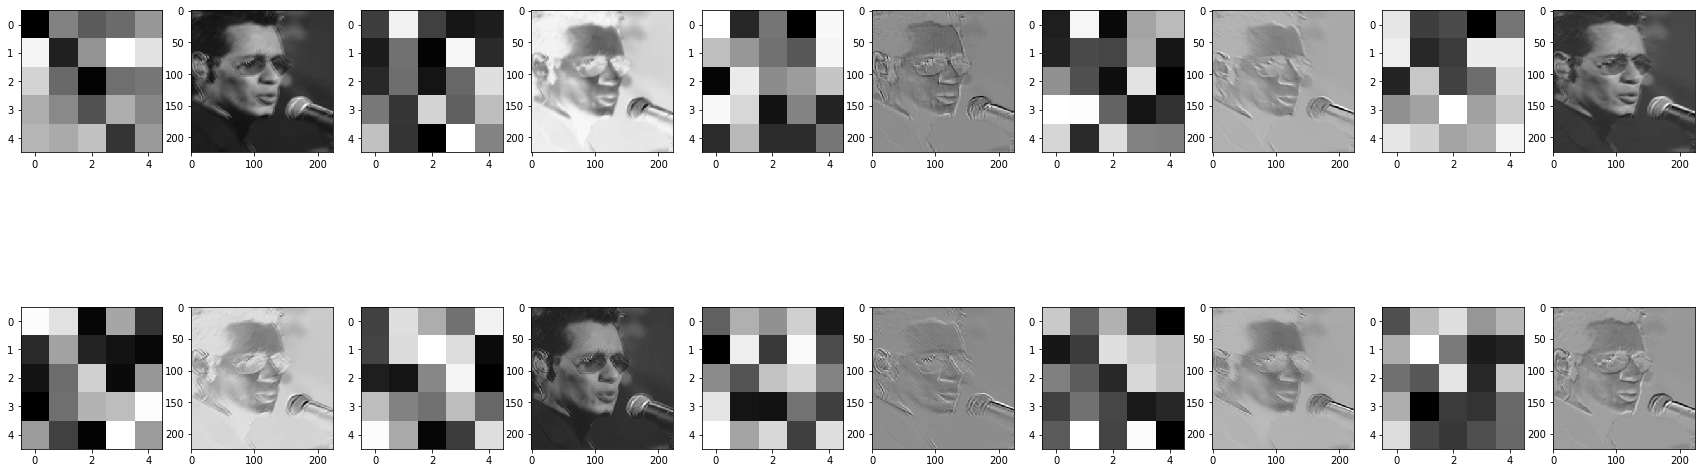

In [109]:
test_images, test_outputs, gt_pts = net_sample_output()

# select an image by index
idx = 1
img = np.squeeze(test_images[idx])
import cv2
plt.imshow(img, cmap='gray')


weights = net.conv1.weight.data
w = weights.cpu().numpy()
img=img.cpu().numpy()
# 1. first conv layer
# for 10 filters
fig=plt.figure(figsize=(30, 10))
columns = 5*2
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
plt.show()

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


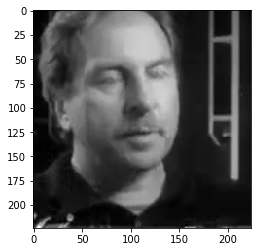

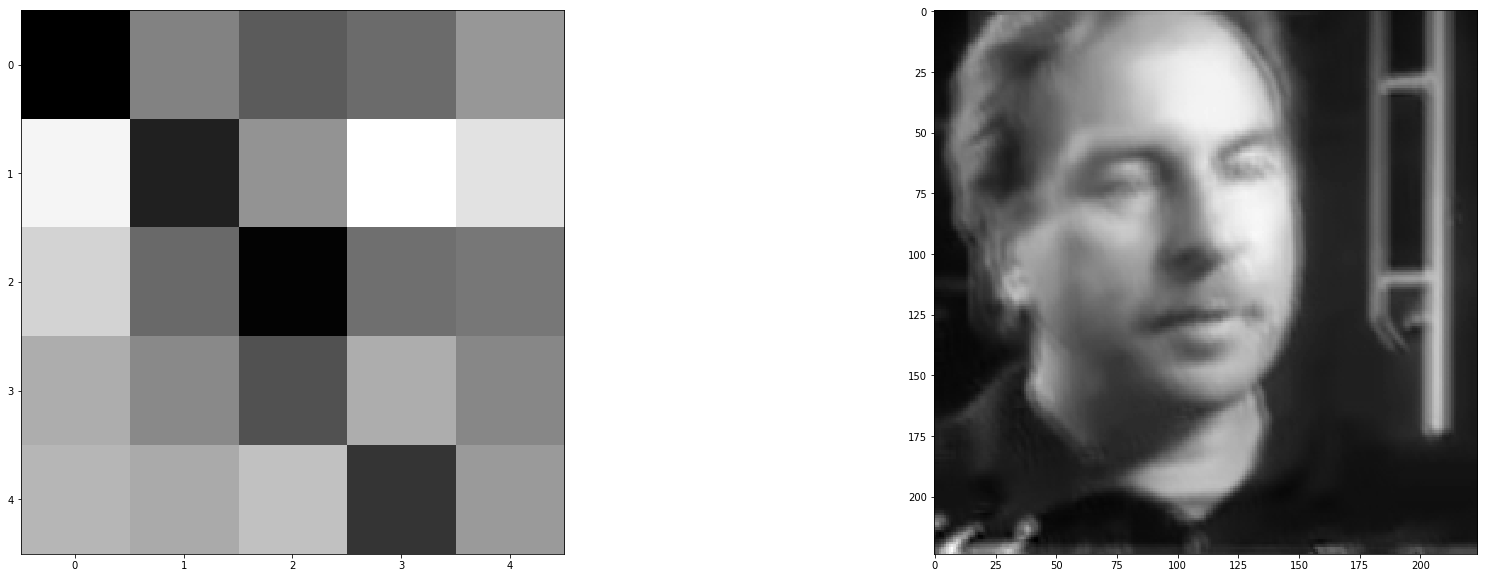

In [110]:
test_images, test_outputs, gt_pts = net_sample_output()

# select an image by index
idx = 1
img = np.squeeze(test_images[idx])
import cv2
plt.imshow(img, cmap='gray')


weights = net.conv1.weight.data
w = weights.cpu().numpy()
img=img.cpu().numpy()
# 1. first conv layer
# for 10 filters
fig=plt.figure(figsize=(30, 10))
columns = 1*2
rows = 1
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
plt.show()

**Answer**: As it is obvious it is bluring out noises so prevent overfitting and also smaller size image with less unimportant features to detect at the later stage.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!